In [185]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np
from keras.models import load_model
# import pytesseract
import math
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np
import configparser

def PredictImg(img):
    # 載入模型
    #縮放圖片大小
    Max_Width=20
    Max_Hight=20
    x_test = []
    # for img in imgs:
    try:
        img = cv2.resize(img, (Max_Width, Max_Hight), interpolation=cv2.INTER_CUBIC)
    except:
        return None
    x_test.append(img)
    x_test = np.array(x_test)
    x_test = x_test.reshape(x_test.shape[0], Max_Width, Max_Hight, 1)
    x_test = 255 - x_test
    x_test = x_test.astype('float32')
    x_test /= 255
    pred = model.predict(x_test,batch_size = 25)
    outdict = ['0','1','2','3','4','5','6','7','8','9']
    pred_result = outdict[np.argmax(pred)]
    return pred_result

#去除掉圖片的雜訊，使用filter來決定可不可以用
def ImageFilter(width,height):
    # 面積太小就算雜訊
    if width<=3 or width>20 or width*height<70 \
        or width*height>400 or height <= 14 or height > 22 or height - width < 5:
        return False 
    else:
        return True

def boundleSort(contours,columnLength,imageType):
    # sortPatten = {x:0,y:1}
    # sort = [x,y]

    #x軸（橫向）
    #y軸（直向）
    #只有第一個格狀列表不用做排序
    if imageType != "1":
        #做Y軸排序
        contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])

    boundle = []
    boundles = []

    for i in range(0,len(contours)):  
        x, y, width, height = cv2.boundingRect(contours[i])  
        # 面積太小就算雜訊
        if ImageFilter(width, height) == False:
            continue
        # print (x, y, width, height)
        #把符合規則的邊界存起來
        boundle.append([x, y, width, height])


    #list 分群
    splitRows = [boundle[i:i+columnLength] for i in range(0,len(boundle),columnLength)]
    for bound in splitRows:
        if imageType != "1":
            # 使用Ｘ軸來排序
            boundles.append(sorted(bound, key=lambda bound: bound[0]))
        else:
            boundles.append([bound[1],bound[0]])

    return boundles
def DrawBoundle(boundle,img,columnLength):
    for i in range(0,len(boundle)):
        for j in range(len(boundle[i])):
            x, y, width, height = boundle[i][j]
            # print (x, y, width, height)
            cv2.rectangle(img, (x, y),
                                        (x + width, 
                                        y + height), (153,153,0), 2) 
            # cv2.putText(img, str((i*columnLength)+j), (x,y), cv2.FONT_HERSHEY_SIMPLEX,
            #     0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return img
def imageProcess(img,THRESH_BINARY_TYPE,threshValue,area,columnLength,imageType):
    # plt.imshow(img)
    # plt.title('original picture')
    # plt.show()



    #切割掉不重要的區域
    crop_img = img.crop(area)
    
    # plt.imshow(crop_img)
    # plt.title('crop_img picture')
    # plt.show()


    img = cv2.cvtColor(np.asarray(crop_img),cv2.COLOR_RGB2BGR)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    originalImg = img.copy()                              
    originalImg = cv2.GaussianBlur(originalImg, (1,1), 1)

    if THRESH_BINARY_TYPE == "THRESH_BINARY_INV":
        #二值化
        ret,originalImg = cv2.threshold(originalImg,threshValue,255,        
                                        cv2.THRESH_BINARY_INV)
    else:
        #二值化
        ret,originalImg = cv2.threshold(originalImg,threshValue,255,        
                                        cv2.THRESH_BINARY)
    #x軸（橫向）
    #y軸（直向）
    #保存圖像處理好的圖片
    #膨脹
    imageProcessDone = cv2.erode(originalImg, (1,2), iterations = 2)
    # plt.imshow(imageProcessDone)
    # plt.title('imageProcessDone')
    # plt.show()


    secondSplitImg = imageProcessDone.copy()
    #把完全看不到文字只剩下填滿黑色的色塊版本去做輪廓辨識
    secondSplitImg ,Splitcontours,hierarchy = cv2.findContours(secondSplitImg,          
                                                    cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    #送去做Boundle排序
    boundle = boundleSort(contours = Splitcontours,
                          columnLength = columnLength,
                          imageType = imageType)

    secondSplitImg = DrawBoundle(boundle = boundle,
                                 img = secondSplitImg,
                                 columnLength = 20)
    plt.imshow(secondSplitImg)
    plt.title("secondSplitImg")
    plt.show()
    return boundle,imageProcessDone

In [175]:

#顯示辨識結果
def showRecognizeResult(img,THRESH_BINARY_TYPE,threshValue,area,columnLength,imageType):
    boundle,imageProcessDone = imageProcess(img = img,
                                            THRESH_BINARY_TYPE = THRESH_BINARY_TYPE,
                                            threshValue = threshValue,
                                            area = area,
                                            columnLength = columnLength,
                                            imageType = imageType)

    #儲存所有號碼圖的辨識結果
    output = []
    DrawContours = imageProcessDone.copy()
    _originalImg = imageProcessDone.copy()
    for i in range(0,len(boundle)):
        for j in range(len(boundle[i])):
            x, y, width, height = boundle[i][j]
            # 面積太小就算雜訊
            if ImageFilter(width, height) == False:
                continue
            newImage=_originalImg[y:y+height,
                            x:x+width]
            predValue = PredictImg(newImage)
            output.append(predValue)
            # plt.imshow(newImage)
            # plt.title(predValue+":"+str(x)+","+str( y)+","+str( width)+","+str( height))
            # plt.show()
            input_dir=("cut_image/")
            if not os.path.isdir(input_dir):
                os.makedirs(input_dir)
            cv2.imwrite("./cut_image/{i}_{predValue}.jpg".format(i=str(i),
                        predValue = predValue),newImage) 
    return output



Type:3
3_3.jpg


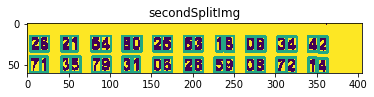

26,21,54,80,25,53,18,09,34,42,71,35,79,31,06,28,59,08,72,14,Type:4
4_3.jpg


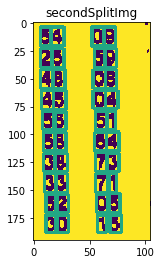

54,25,48,45,56,56,38,33,52,30,09,59,08,04,51,64,73,71,05,15,Type:5
5_3.jpg


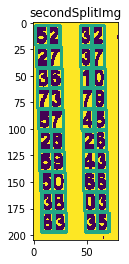

52,27,36,73,57,28,59,50,38,63,32,37,10,79,45,26,43,66,03,35,Type:6
6_3.jpg


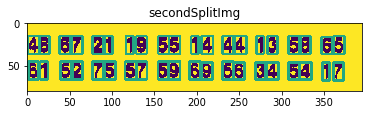

48,67,21,19,55,14,44,13,58,65,61,52,75,57,59,69,56,34,54,17,Type:7
7_3.jpg


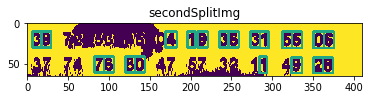

38,76,80,41,93,63,11,55,02,86,Type:8
8_3.jpg


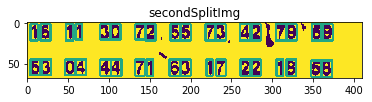

16,11,30,72,55,73,42,71,98,59,53,04,44,71,63,17,22,58,Type:1
1_3.jpg


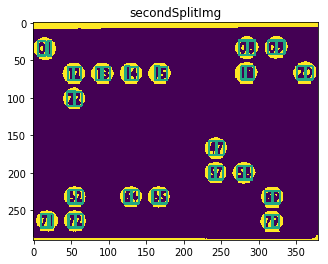

79,72,71,69,65,64,52,58,57,47,22,15,14,13,12,18,20,01,08,09,Type:2
2_3.jpg


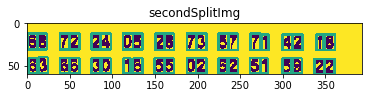

68,72,24,05,28,73,57,71,42,18,63,66,30,16,55,02,62,51,59,22,Type:3
3_3.jpg


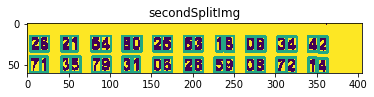

26,21,54,80,25,53,18,09,34,42,71,35,79,31,06,28,59,08,72,14,Type:4
4_3.jpg


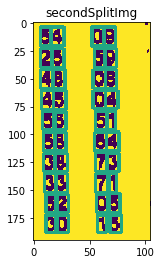

54,25,48,45,56,56,38,33,52,30,09,59,08,04,51,64,73,71,05,15,Type:5
5_3.jpg


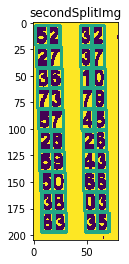

52,27,36,73,57,28,59,50,38,63,32,37,10,79,45,26,43,66,03,35,Type:6
6_3.jpg


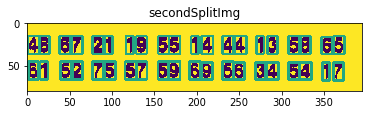

48,67,21,19,55,14,44,13,58,65,61,52,75,57,59,69,56,34,54,17,Type:7
7_3.jpg


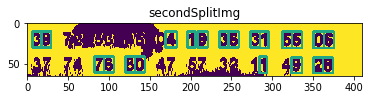

38,76,80,41,93,63,11,55,02,86,Type:8
8_3.jpg


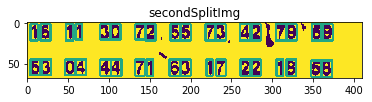

16,11,30,72,55,73,42,71,98,59,53,04,44,71,63,17,22,58,Type:1
1_3.jpg


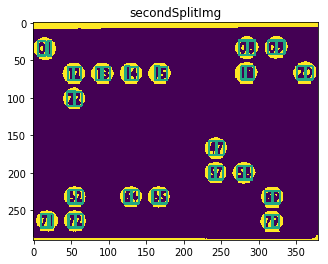

79,72,71,69,65,64,52,58,57,47,22,15,14,13,12,18,20,01,08,09,Type:2
2_3.jpg


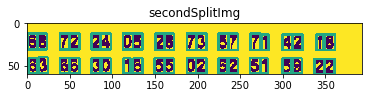

68,72,24,05,28,73,57,71,42,18,63,66,30,16,55,02,62,51,59,22,Type:3
3_3.jpg


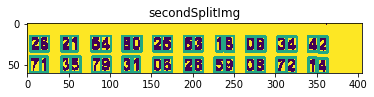

26,21,54,80,25,53,18,09,34,42,71,35,79,31,06,28,59,08,72,14,Type:4
4_3.jpg


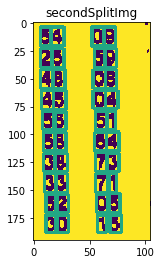

54,25,48,45,56,56,38,33,52,30,09,59,08,04,51,64,73,71,05,15,Type:5
5_3.jpg


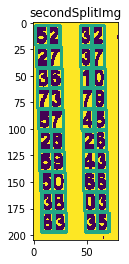

52,27,36,73,57,28,59,50,38,63,32,37,10,79,45,26,43,66,03,35,Type:6
6_3.jpg


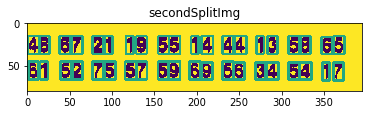

48,67,21,19,55,14,44,13,58,65,61,52,75,57,59,69,56,34,54,17,Type:7
7_3.jpg


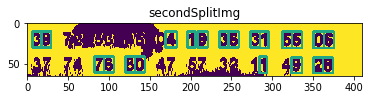

38,76,80,41,93,63,11,55,02,86,Type:8
8_3.jpg


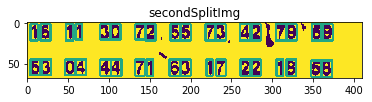

16,11,30,72,55,73,42,71,98,59,53,04,44,71,63,17,22,58,Type:1
1_3.jpg


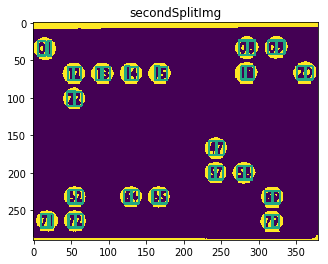

79,72,71,69,65,64,52,58,57,47,22,15,14,13,12,18,20,01,08,09,Type:2
2_3.jpg


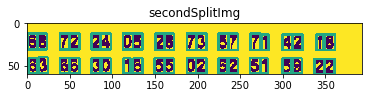

68,72,24,05,28,73,57,71,42,18,63,66,30,16,55,02,62,51,59,22,Type:3
3_3.jpg


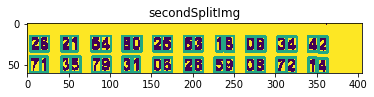

26,21,54,80,25,53,18,09,34,42,71,35,79,31,06,28,59,08,72,14,Type:4
4_3.jpg
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-199-685e04349722>", line 30, in <module>
    output = showRecognizeResult(img = img,THRESH_BINARY_TYPE = TYPE,threshValue = threshValue,area = area,columnLength = columnLength,imageType = imageType)
  File "<ipython-input-175-6a154b2f2630>", line 9, in showRecognizeResult
    imageType = imageType)
  File "<ipython-input-185-850177b3532b>", line 149, in imageProcess
    plt.show()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py", line 253, in show
    return _show(*args, **kw)
  File "/Library/Frame

KeyboardInterrupt: 

In [199]:


#傳入圖片與圖片類型
def combineResult(img,imageType):
    print ("Type:" + imageType)
    config = configparser.ConfigParser()
    config.read('config.ini')
    #圖片要辨識的類型，共八種

    #x軸（橫向）
    #y軸（直向）
    #讀取切割區域的座標範圍
    _config = config[imageType]
    area = tuple(int(value) for value in _config["area"].split(","))

    #讀取二值化閥值
    threshValue = int(_config["threshValue"])
    #二值化方案（THRESH_BINARY_INV,THRESH_BINARY_INV_INV）
    TYPE = _config["THRESH_BINARY_TYPE"]
    #橫行直列的數量
    columnLength = int(_config["columnLength"])


    # img = Image.open(imageType + '_3.jpg')
    output = showRecognizeResult(img = img,THRESH_BINARY_TYPE = TYPE,threshValue = threshValue,area = area,columnLength = columnLength,imageType = imageType)
    #每兩個數字為一排
    step = 2
    output = [output[i:i+step] for i in range(0,len(output),step)]
    
    
    #賽車與套圈圈的數字要做特別處理
    if imageType == "4" or imageType == "5":
        #因為有兩排，現在想先知道切片要切第一排與第二排要留多少
        otherRowItemIndex = 10 - (20 - len(output))
        # output.reverse()
        outFirstLine = []
        outSecondLine = []
        
        for i in range(len(output)):
            try:    
                #輸出1,3,5,7,9 行，因為數字是直列下來的
                if i%2 == 1:
                    outSecondLine.append(output[i])
                    # print (ele[0]+ele[1]+",",end='')
                else:
                    if len(outFirstLine) < otherRowItemIndex:
                        outFirstLine.append(output[i])
                    else:
                        #第二排的數字出來了，那就順位繼續
                        outSecondLine.append(output[i])
            except:
                continue
        output = outSecondLine+outFirstLine
    
    for ele in output:
        try:
            print (ele[0]+ele[1] + "," , end='')
        except:
            continue
    return output


model = load_model('Models/model.h5')
#輸入程式啟動時，下一個是什麼圖形
firstPatten = int(input("請輸入下一個會顯示的動畫類型"))
imageType = firstPatten
img = Image.open(imageType + '_3.jpg')
combineResult(img = img,imageType = imageType)
firstPatten += 1 

#回到初始的類別
if firstPatten > 8:
    firstPatten = 1